## **Customer Churn Prediction with Random Forest & XGBoost**


---


This project focuses on predicting customer churn using two powerful ensemble methods: Random Forest and XGBoost. To address class imbalance in the dataset, **SMOTE** (Synthetic Minority Over-sampling Technique) is applied, ensuring fairer model training and improved performance on minority classes.
The workflow includes:

*   Exploratory Data Analysis (EDA) to understand churn patterns
*   Data preprocessing and feature encoding
*   SMOTE-based resampling to balance churn classes
*   Model training and evaluation using accuracy, confusion matrices, and classification reports
*   Hyperparameter tuning via GridSearchCV for both classifiers

This approach enables robust churn prediction and highlights the impact of
balancing techniques on model fairness and accuracy.


---



## **Import Required Libraries**

In [21]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & Model Selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE

# Warnings
import warnings
warnings.filterwarnings("ignore")


## **Exploratory Data Analysis**

In [4]:
df = pd.read_excel("CustomerChurn.xlsx")
df.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [20]:
# rows and columns
df.shape

(7032, 21)

In [6]:
# Convert 'Total Charges' to numeric — handles any text, blanks, or errors
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")

# Drop rows with missing Total Charges
df = df.dropna(subset=["Total Charges"])

# Drop irrelevant identifier columns
df_cleaned = df.drop(columns=["Customer ID", "LoyaltyID"])

# Preview the cleaned data
df_cleaned.head()

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


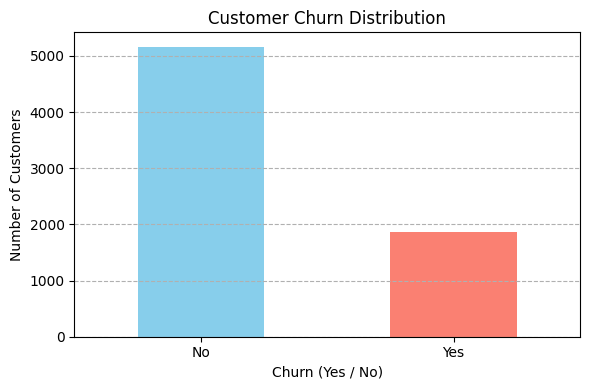

In [7]:
churn_counts = df_cleaned["Churn"].value_counts()

# Plot churn distribution
plt.figure(figsize=(6, 4))
churn_counts.plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Customer Churn Distribution")
plt.xlabel("Churn (Yes / No)")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

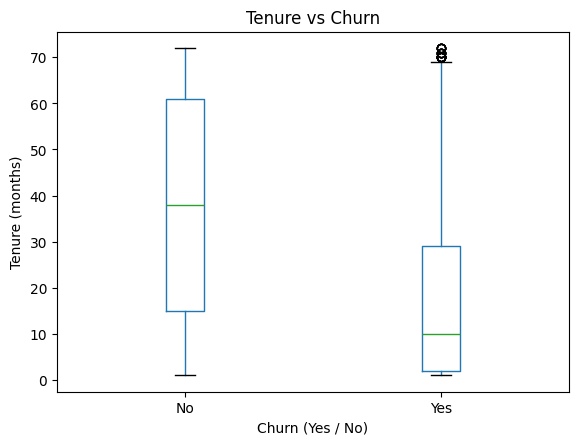

In [8]:
# Visualize how long customers stayed before churning
plt.figure(figsize=(8, 5))
df_cleaned.boxplot(column="Tenure", by="Churn", grid=False)
plt.title("Tenure vs Churn")
plt.suptitle("")  # Remove default Pandas title
plt.xlabel("Churn (Yes / No)")
plt.ylabel("Tenure (months)")
plt.show()

<Figure size 800x500 with 0 Axes>

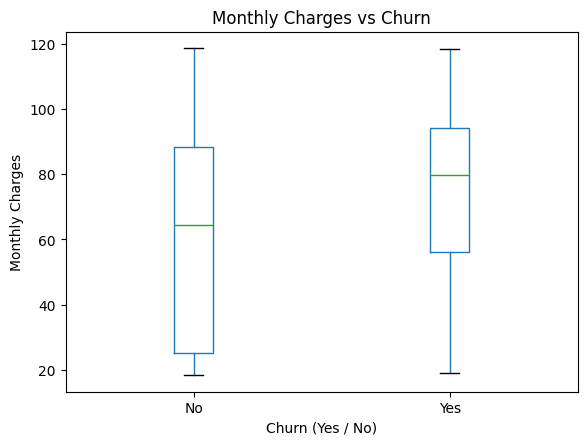

In [9]:
# Visualize how monthly charges relate to churn
plt.figure(figsize=(8, 5))
df_cleaned.boxplot(column="Monthly Charges", by="Churn", grid=False)
plt.title("Monthly Charges vs Churn")
plt.suptitle("")
plt.xlabel("Churn (Yes / No)")
plt.ylabel("Monthly Charges")
plt.show()

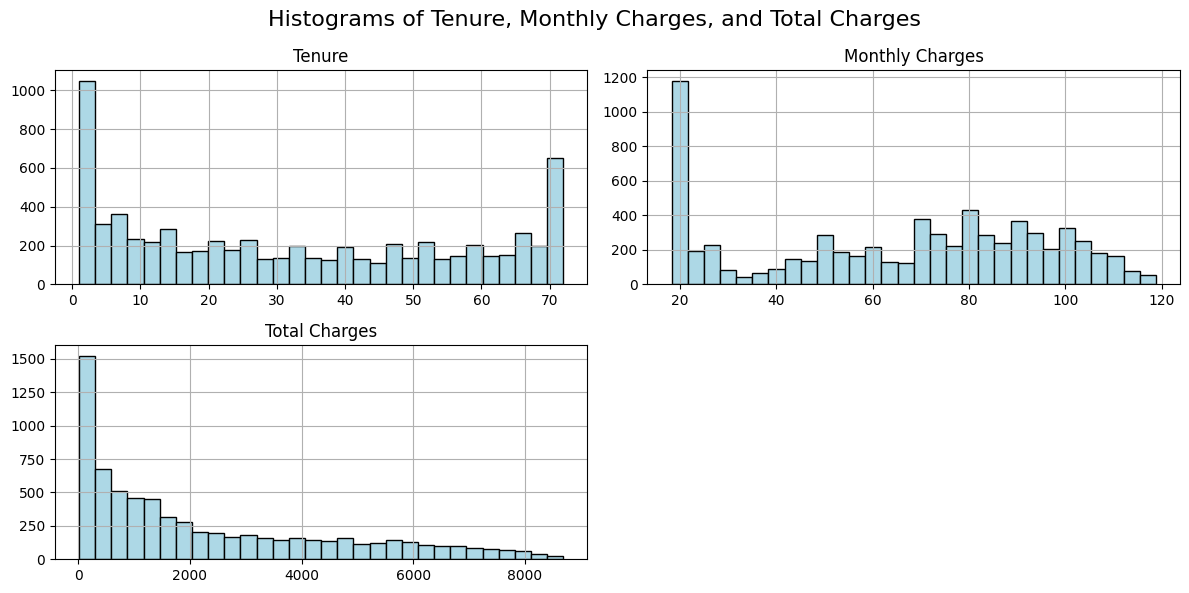

In [10]:
# Plot histograms of numeric features to understand distribution
numeric_cols = ["Tenure", "Monthly Charges", "Total Charges"]
df_cleaned[numeric_cols].hist(bins=30, figsize=(12, 6), color="lightblue", edgecolor="black")
plt.suptitle("Histograms of Tenure, Monthly Charges, and Total Charges", fontsize=16)
plt.tight_layout()
plt.show()

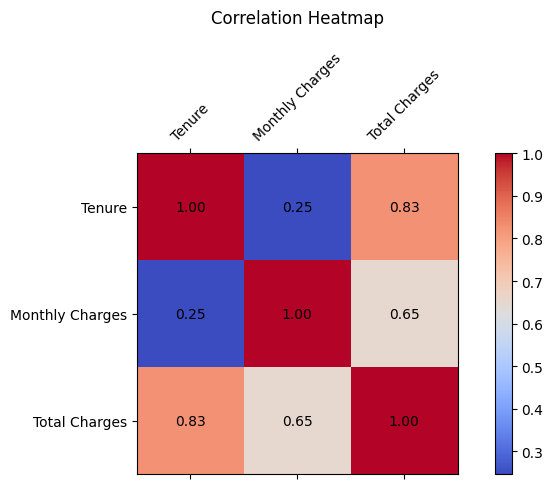

In [11]:
# Correlation matrix for numeric columns
correlation = df_cleaned[["Tenure", "Monthly Charges", "Total Charges"]].corr()

# Manual heatmap without seaborn
fig, ax = plt.subplots(figsize=(8, 5))
cax = ax.matshow(correlation, cmap="coolwarm")
plt.title("Correlation Heatmap", pad=20)

plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=45)
plt.yticks(range(len(correlation.columns)), correlation.columns)

# Add color scale and values
fig.colorbar(cax)
for (i, j), val in np.ndenumerate(correlation.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

## **Feature Encoding & Class Balancing**
Categorical features are encoded using LabelEncoder, and class imbalance is addressed with SMOTE to ensure fair and effective model training.

In [12]:
# Create a working copy
df_encoded = df.copy()

# Label encode object-type columns after converting to string
le = LabelEncoder()

for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = df_encoded[col].astype(str)  # Convert all values to string
        df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,5365,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,152148,3953,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,326527,2558,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,845894,5524,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,503388,6500,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


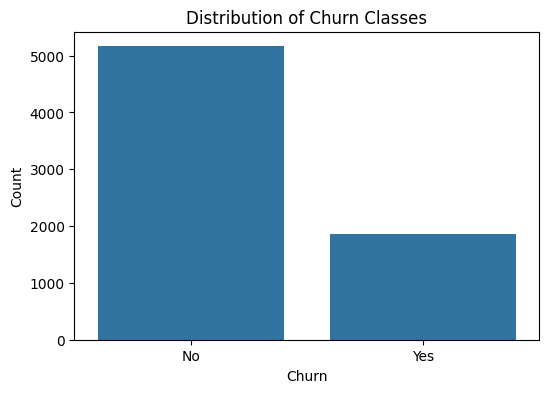

In [13]:
# Check class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn Classes')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


In [14]:
# Split features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Train-test split before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

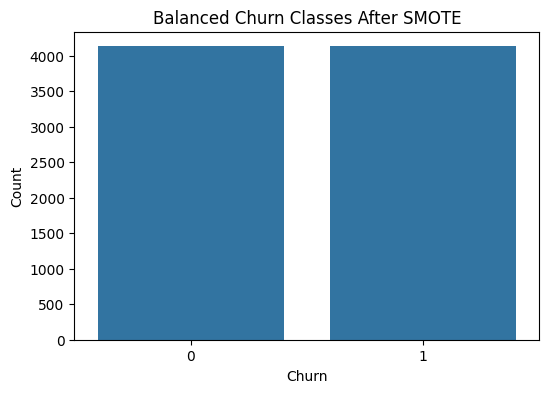

In [15]:
# Plot class distribution after SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_bal)
plt.title('Balanced Churn Classes After SMOTE')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

## **Train & Tune Random Forest Classifier**
A Random Forest model is trained on the SMOTE-balanced dataset. Performance is evaluated using accuracy, confusion matrix, and classification report. Hyperparameter tuning is performed using GridSearchCV to optimize model depth, leaf size, and number of estimators for improved predictive accuracy.

In [118]:
# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluation: Accuracy, Confusion Matrix, Classification Report
print("Random Forest Accuracy on Test Set:", rf_model.score(X_test, y_test))

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:\n", conf_matrix_rf)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy on Test Set: 0.7746979388770433

Confusion Matrix:
 [[869 164]
 [153 221]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.71      1407
weighted avg       0.78      0.77      0.78      1407



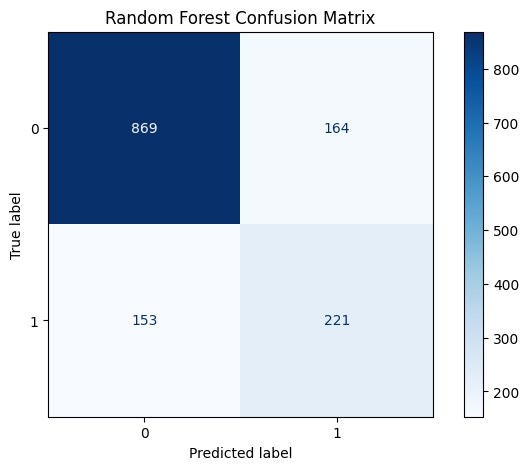

In [119]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, rf_model.predict(X_test))

# Create the ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [120]:
# Define hyperparameters
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_bal, y_train_bal)

# Best parameters and score
print("Random Forest Best Params:", rf_grid.best_params_)
print("Best Accuracy (Train CV):", rf_grid.best_score_)

# Final model with best params
best_rf = rf_grid.best_estimator_

Random Forest Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Accuracy (Train CV): 0.8399515738498788


## **Train & Tune XGBoost Classifier**
An XGBoost model is trained on the SMOTE-balanced dataset. Model performance is evaluated using accuracy, confusion matrix, and classification report. Hyperparameter tuning is performed via GridSearchCV to optimize parameters such as tree depth, learning rate, number of estimators, and subsampling ratio for enhanced predictive performance.

In [125]:
# Train XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Classifier
Accuracy: 0.7583511016346838
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      1033
           1       0.54      0.55      0.55       374

    accuracy                           0.76      1407
   macro avg       0.69      0.69      0.69      1407
weighted avg       0.76      0.76      0.76      1407



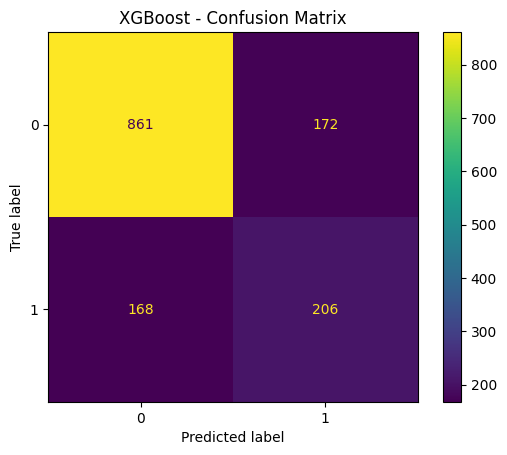

In [126]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
plt.title("XGBoost - Confusion Matrix")
plt.show()

In [127]:
# Hyperparameter Grid
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

#intialize GridSearchCV
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=xgb_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# FIT TO BALANCE DATA
xgb_grid.fit(X_train_bal, y_train_bal)

# RESULTS
print("XGBoost Best Params:", xgb_grid.best_params_)
print("Best Accuracy (Train CV):", round(xgb_grid.best_score_, 4))

best_xgb = xgb_grid.best_estimator_


XGBoost Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best Accuracy (Train CV): 0.8378


## **Comparaing XGBoost and Random Forest**

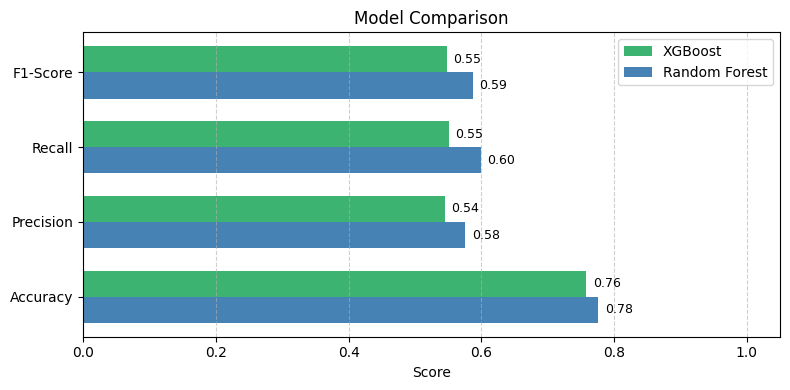

In [128]:
# Metrics and scores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1]
xgb_scores = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 4))

# Bars
bars_xgb = plt.barh(x + width/2, xgb_scores, height=width, label='XGBoost', color='MediumSeaGreen')
bars_rf = plt.barh(x - width/2, rf_scores, height=width, label='Random Forest', color='SteelBlue')

# Add value labels
for bar in bars_rf:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center', fontsize=9)

for bar in bars_xgb:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center', fontsize=9)

# Styling
plt.xlabel('Score')
plt.yticks(x, metrics)
plt.xlim(0, 1.05)
plt.title('Model Comparison')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


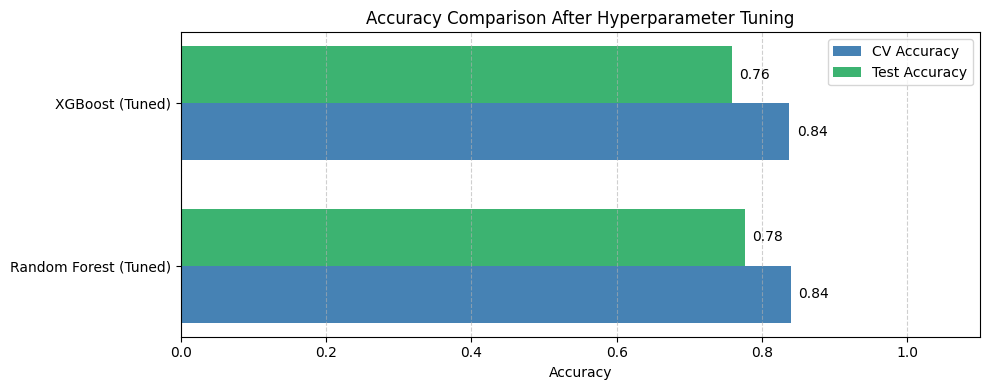

In [129]:
models = ['Random Forest (Tuned)', 'XGBoost (Tuned)']
cv_acc = [rf_grid.best_score_, xgb_grid.best_score_]
test_acc = [rf_accuracy, xgb_accuracy]

x = np.arange(len(models))
height = 0.35  # Bar thickness

plt.figure(figsize=(10, 4))
plt.barh(x, cv_acc, height=height, label='CV Accuracy', color='steelblue')
plt.barh(x + height, test_acc, height=height, label='Test Accuracy', color='mediumseagreen')

# Add value labels
for i in range(len(models)):
    plt.text(cv_acc[i] + 0.01, x[i], f'{cv_acc[i]:.2f}', va='center', fontsize=10)
    plt.text(test_acc[i] + 0.01, x[i] + height, f'{test_acc[i]:.2f}', va='center', fontsize=10)

plt.yticks(x + height/2, models)
plt.xlabel('Accuracy')
plt.xlim(0, 1.1)  # Extra space for text
plt.title('Accuracy Comparison After Hyperparameter Tuning')
plt.legend(loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## **Conclusion**


---


This project successfully demonstrated the effectiveness of ensemble learning techniques—Random Forest and XGBoost—in predicting customer churn. By applying SMOTE to address class imbalance and conducting GridSearchCV for hyperparameter tuning, both models achieved robust performance, with CV accuracies of 83.92% (RF) and 83.78% (XGB) respectively.

Key takeaways include:


*   Random Forest slightly outperformed XGBoost on the test set, showing better generalization and lower overfitting.
*   SMOTE significantly improved minority class recall, making the models more equitable in churn detection.

*   Hyperparameter tuning played a crucial role in optimizing model performance and reducing bias.



---




